In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix as CM
from sklearn.metrics import brier_score_loss
from sklearn.metrics import log_loss
import datetime
import sys
sys.path.append('../../')
from PortfolioAnalysis import Backtest
from PortfolioAnalysis import Model

# Data Clean

In [137]:
temp = pd.read_csv("../Risk_Parity_Model/view.csv",index_col=0)
ast = temp.columns
df_date = pd.read_excel("../../Data/Index.xls",index_col=0).dropna().index
def Data_Clean(gap):
    # data load
    df_x = pd.read_csv("../../Data/Macro_PCA.csv",index_col=0).iloc[120:,]
    df_x.index = pd.DatetimeIndex(df_x.index)

    df_y = pd.read_excel("../../Data/Index.xls",index_col=0)[gap:252*6+gap]
    df_y.index = pd.DatetimeIndex(df_y.index)


    temp1 = ((df_y - df_y.shift(1))[1:]>0).astype("int")
    #temp2 = ((df_y - df_y.shift(1))[1:]<0).astype("int")
    df_y = temp1 

    last_dates_of_the_month = []
    dt_y_year = df_y.index
    dt_y_year = dt_y_year.groupby(dt_y_year.year)
    for dt in dt_y_year:
        dt = dt_y_year[dt]
        dt_month_group_dict = dt.groupby(dt.month)
        for month in dt_month_group_dict:
            last_date = max(dt_month_group_dict[month])
            last_dates_of_the_month.append(last_date)
    date_y = last_dates_of_the_month 

    date_x = str(date_y[0].year)+"-"+str(date_y[0].month)
    df_y = df_y.loc[date_y,ast]
    df_x = df_x.loc[date_x:,:]

    df_x = df_x.shift(-3).dropna()
    df_x = df_x.iloc[:df_y.shape[0],:]
    df_x.index = df_y.index
    return [df_x,df_y]

# Train

In [138]:
def NBModel(df_x,df_y,i,tsize=0.2):
    Xtrain,Xtest,Ytrain,Ytest = train_test_split(df_x,df_y.loc[:,i],test_size = tsize,random_state=1)
    gnb = GaussianNB().fit(Xtrain,Ytrain)

    # accuracy
    acc_score = gnb.score(Xtest,Ytest)

    # predict
    Y_pred = gnb.predict(Xtest)
    prob = gnb.predict_proba(Xtest)

    # CM
    cm = CM(Ytest,Y_pred)

    # Brier Score
    bs = brier_score_loss(Ytest, prob[:,1], pos_label=1)

    # Log
    ll = log_loss(Ytest,prob)
    df_info = pd.DataFrame({"Accuracy_Score":acc_score,"Brier_Score":bs,"Log_Loss":ll},index = [i])
    return [prob[-1],df_info]

In [139]:
def get_view(df_x,df_y):
    # probability of "1" minus 0.5
    # if positive -- that is, prob of 1 > 0.5 -- we conjecture price will go up
    v=[]
    df_info = pd.DataFrame({"Accuracy_Score":np.nan,"Brier_Score":np.nan,"Log_Loss":np.nan},index=['NAN'])
    for i in ast:
        (a,b) = NBModel(df_x,df_y,i)
        v.append(a[1]-0.5)
        df_info = pd.concat([df_info,b],axis=0)
    df_info.dropna(inplace=True)
    v = np.array(v)

    # the sum of weight should be equal to 1
    v = v/v.sum()
    return (v,df_info)

In [140]:
# calculate the subjective view
lg = len(df_date)
info = []
view_sbj = []
std_sbj = []
gap = 0
while(1):
    if(gap+252*6+21*4>lg):
        break
    (df_x,df_y) = Data_Clean(gap)
    (v,df_info) = get_view(df_x,df_y)
    view_sbj.append(v)
    info.append(df_info)
    
    # rolling forwards
    gap += 21*3
    print("count: "+str(int(gap/63)))

count: 1
count: 2
count: 3
count: 4
count: 5
count: 6
count: 7
count: 8
count: 9
count: 10
count: 11
count: 12
count: 13
count: 14
count: 15
count: 16
count: 17
count: 18


# Backtest

In [141]:
df_index = pd.read_excel("../../Data/Index.xls",index_col=0).dropna().loc[:,ast]

In [142]:
# calculate the expected return
gap = 0
i = 0
df_fr = pd.DataFrame(np.repeat(0,252*2))
q = []
while(1):
    if(i==18):
        break
    df_bt = df_index.iloc[gap+252*4:252*6+gap,:]
    df_view_temp = np.repeat(view_sbj[i].reshape(1,15),252*2,axis=0)
    BT = Backtest.Backtest(df_bt.index,df_bt,df_view_temp,df_fr,"D")
    q.append(BT.annualized_return().mean())
    np.array(view_sbj)
    i+=1
    gap+=21*3
np.array(q)

array([-0.14697862,  0.58189926,  0.21763414,  0.12813541,  0.16358175,
        0.05293124,  0.08480434,  0.03140352,  0.01928133, -0.05914835,
        0.0543359 ,  0.1556103 , -0.00978151, -0.05060238, -0.2641427 ,
       -0.20063382, -0.02487758,  0.00063078])

In [145]:
df_sbj = pd.DataFrame(np.repeat(view_sbj,63,axis=0),index=temp.index)
df_sbj.columns = ast

df_sbj['Q'] = np.repeat(q,63)
df_sbj.index = temp_index
df_sbj.to_csv("view.csv")

In [146]:
df_sbj = pd.read_csv("view.csv",index_col=0)

In [147]:
df_fr = pd.DataFrame(np.repeat(0,1197))



df_bm = pd.DataFrame(np.repeat(np.array([[1/15,]*15]),63*18,axis=0))
df_bm.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667
1,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667
2,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667
3,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667
4,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667,0.066667


In [148]:
BT = Backtest.Backtest(df_sbj.index,df_index.iloc[252*6:252*6+63*18],df_sbj.iloc[:,:-1],df_fr,"D")

BT.get_info()

,Sharpe,Annualized Return,Annualized Volatility,Maximum Drawdown
Value,0.164954,0.119444,0.724108,0.142392


In [149]:
BTM = Backtest.Backtest(df_sbj.index,df_index.iloc[252*6:252*6+63*18],df_bm,df_fr,"D")

BTM.get_info()

,Sharpe,Annualized Return,Annualized Volatility,Maximum Drawdown
Value,0.021748,0.025452,1.170299,0.298374


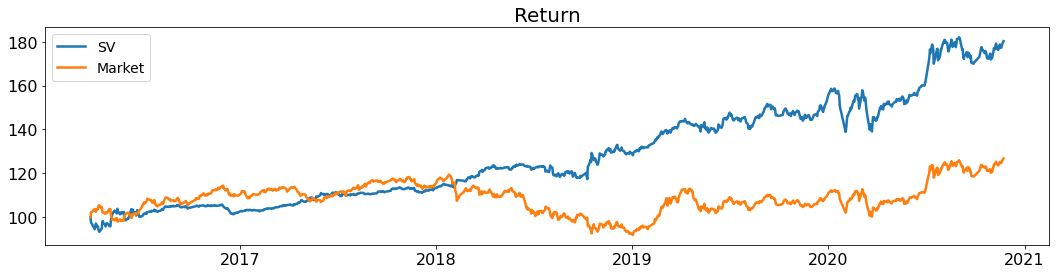

In [150]:
Backtest.Plot2(df_sbj.index,BT.df_asset,BTM.df_asset,"Return","SV","Market")

In [151]:
Asset = pd.DataFrame([BT.df_asset,BTM.df_asset]).T
Asset.index = df_sbj.index
Asset.columns = ['SV','Market']

Asset.to_csv("SV_Asset.csv")

In [152]:
sum(round(df_sbj.iloc[:,:-1].sum(axis=1),3)!=1)

0